In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Function for loading notMNIST Dataset
def loadData(datafile = "notMNIST.npz"):
    with np.load(datafile) as data:
        Data, Target = data["images"].astype(np.float32), data["labels"]
        np.random.seed(7)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [ ]:
# Custom Dataset class.
class notMNIST(Dataset):
    def __init__(self, annotations, images, transform=None, target_transform=None):
        self.img_labels = annotations
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#Define FNN
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()

        #first hidden layer
        self.linear1 = nn.Linear(784,10)
        #second hidden layer
        self.linear2 = nn.Linear(10,10)
        #output layer
        self.linear3 = nn.Linear(10,10)

    def forward(self, x):
        #TODO
        #DEFINE YOUR FORWARD FUNCTION HERE
        x_flatten = torch.flatten(x, start_dim=1)
        x_layer1 = self.linear1(x_flatten)
        x_layer1_relu = F.relu(x_layer1)
        x_layer2 = self.linear2(x_layer1_relu)
        x_layer2_relu = F.relu(x_layer2)
        x_layer3 = self.linear3(x_layer2_relu)

        return x_layer3



In [ ]:
# Commented out IPython magic to ensure Python compatibility.
# Compute accuracy
def get_accuracy(model, dataloader):

    model.eval()
    device = next(model.parameters()).device
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # TODO
            # Return the accuracy
            total += len(labels)
            output = model(images)
            predict = torch.argmax(output, dim=1)

            accuracy += predict.eq(labels.view_as(predict)).sum().item() #??


    accuracy /= total

    return accuracy


In [ ]:
def train(model, device, learning_rate, train_loader, val_loader, test_loader, num_epochs=50, verbose=False):
  #TODO
  # Define your cross entropy loss function here
  # Use cross entropy loss
  criterion =nn.CrossEntropyLoss()

  #TODO
  # Define your optimizer here
  # Use AdamW optimizer, set the weights, learning rate argument.
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


  acc_hist = {'train':[], 'val':[], 'test': []}

  for epoch in range(num_epochs):
    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # TODO
        # Follow the step in the tutorial

        predict = model(images)
        loss = criterion(predict, labels)
        optimizer.zero_grad()
        loss.backward()


        ## update model params
        optimizer.step()

    model.eval()
    acc_hist['train'].append(get_accuracy(model, train_loader))
    acc_hist['val'].append(get_accuracy(model, val_loader))
    acc_hist['test'].append(get_accuracy(model, test_loader))

    if verbose:
      print('Epoch: %d | Train Accuracy: %.2f | Validation Accuracy: %.2f | Test Accuracy: %.2f' \
          %(epoch, acc_hist['train'][-1], acc_hist['val'][-1], acc_hist['test'][-1]))

  return model, acc_hist


In [ ]:
def plot_training_history(acc_hist,lr):
  title = "Accuracy Curve at learning rate of "+ str(lr)
  plt.title(title)
  plt.plot(acc_hist['train'], label="Train")
  plt.plot(acc_hist['test'], label="Test")
  plt.xlabel("# of epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


In [ ]:
def experiment(learning_rate=0.0001, num_epochs=50, verbose=False):
  # Use GPU if it is available.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Inpute Batch size:
  BATCH_SIZE = 32

  # Convert images to tensor
  transform = transforms.Compose(
      [transforms.ToTensor()])

  # Get train, validation and test data loader.
  trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

  train_data = notMNIST(trainTarget, trainData, transform=transform)
  val_data = notMNIST(validTarget, validData, transform=transform)
  test_data = notMNIST(testTarget, testData, transform=transform)


  train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  # Specify which model to use
  model = FNN()

  # Loading model into device
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  model, acc_hist = train(model, device, learning_rate, train_loader, val_loader, test_loader, num_epochs=num_epochs, verbose=verbose)

  # Release the model from the GPU (else the memory wont hold up)
  model.cpu()

  return model, acc_hist

In [ ]:
def compare_lr():
  md,hist1 = experiment(learning_rate=0.1, num_epochs=50, verbose=True)
  plot_training_history(hist1,0.1)
  md,hist2 = experiment(learning_rate=0.01, num_epochs=50, verbose=True)
  plot_training_history(hist2,0.01)
  md,hist3 = experiment(learning_rate=0.001, num_epochs=50, verbose=True)
  plot_training_history(hist3,0.001)
  md,hist4 = experiment(learning_rate=0.0001, num_epochs=50, verbose=True)
  plot_training_history(hist4,0.0001)

Epoch: 0 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.10
Epoch: 1 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.09
Epoch: 2 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.09
Epoch: 3 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.11
Epoch: 4 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.10
Epoch: 5 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.10
Epoch: 6 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.10
Epoch: 7 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.09
Epoch: 8 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.09
Epoch: 9 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.11
Epoch: 10 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.09
Epoch: 11 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 0.10
Epoch: 12 | Tr

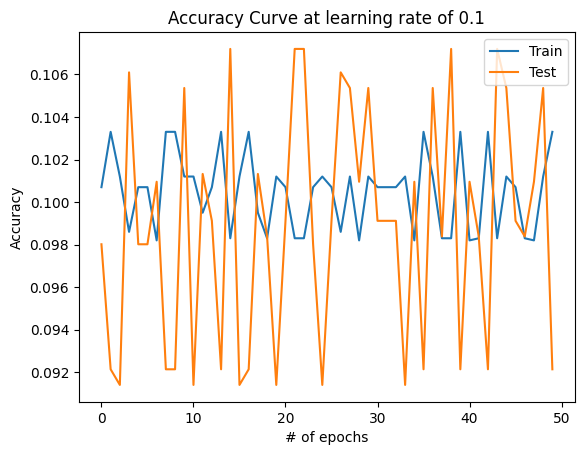

Epoch: 0 | Train Accuracy: 0.81 | Validation Accuracy: 0.80 | Test Accuracy: 0.82
Epoch: 1 | Train Accuracy: 0.87 | Validation Accuracy: 0.86 | Test Accuracy: 0.86
Epoch: 2 | Train Accuracy: 0.85 | Validation Accuracy: 0.83 | Test Accuracy: 0.84
Epoch: 3 | Train Accuracy: 0.88 | Validation Accuracy: 0.86 | Test Accuracy: 0.87
Epoch: 4 | Train Accuracy: 0.88 | Validation Accuracy: 0.85 | Test Accuracy: 0.86
Epoch: 5 | Train Accuracy: 0.88 | Validation Accuracy: 0.86 | Test Accuracy: 0.87
Epoch: 6 | Train Accuracy: 0.87 | Validation Accuracy: 0.85 | Test Accuracy: 0.86
Epoch: 7 | Train Accuracy: 0.86 | Validation Accuracy: 0.85 | Test Accuracy: 0.85
Epoch: 8 | Train Accuracy: 0.87 | Validation Accuracy: 0.85 | Test Accuracy: 0.85
Epoch: 9 | Train Accuracy: 0.88 | Validation Accuracy: 0.86 | Test Accuracy: 0.87
Epoch: 10 | Train Accuracy: 0.90 | Validation Accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 11 | Train Accuracy: 0.90 | Validation Accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 12 | Tr

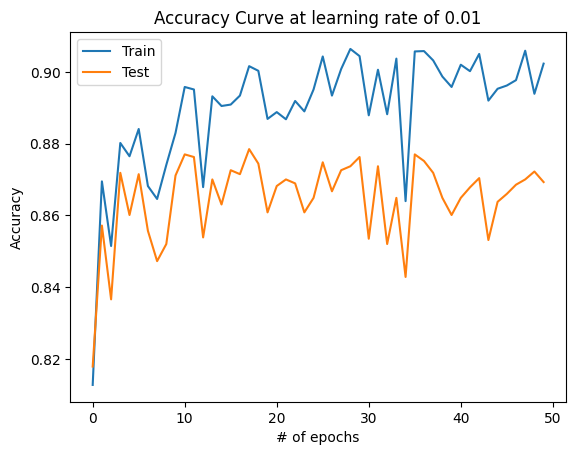

Epoch: 0 | Train Accuracy: 0.82 | Validation Accuracy: 0.82 | Test Accuracy: 0.82
Epoch: 1 | Train Accuracy: 0.86 | Validation Accuracy: 0.86 | Test Accuracy: 0.86
Epoch: 2 | Train Accuracy: 0.86 | Validation Accuracy: 0.86 | Test Accuracy: 0.86
Epoch: 3 | Train Accuracy: 0.87 | Validation Accuracy: 0.86 | Test Accuracy: 0.87
Epoch: 4 | Train Accuracy: 0.87 | Validation Accuracy: 0.87 | Test Accuracy: 0.87
Epoch: 5 | Train Accuracy: 0.88 | Validation Accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 6 | Train Accuracy: 0.88 | Validation Accuracy: 0.87 | Test Accuracy: 0.88
Epoch: 7 | Train Accuracy: 0.89 | Validation Accuracy: 0.88 | Test Accuracy: 0.88
Epoch: 8 | Train Accuracy: 0.89 | Validation Accuracy: 0.88 | Test Accuracy: 0.88
Epoch: 9 | Train Accuracy: 0.89 | Validation Accuracy: 0.88 | Test Accuracy: 0.89
Epoch: 10 | Train Accuracy: 0.89 | Validation Accuracy: 0.88 | Test Accuracy: 0.89
Epoch: 11 | Train Accuracy: 0.90 | Validation Accuracy: 0.88 | Test Accuracy: 0.89
Epoch: 12 | Tr

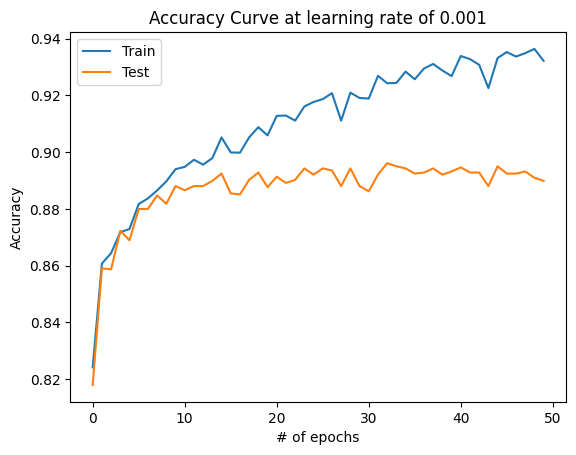

Epoch: 0 | Train Accuracy: 0.39 | Validation Accuracy: 0.38 | Test Accuracy: 0.40
Epoch: 1 | Train Accuracy: 0.61 | Validation Accuracy: 0.61 | Test Accuracy: 0.60
Epoch: 2 | Train Accuracy: 0.67 | Validation Accuracy: 0.68 | Test Accuracy: 0.67
Epoch: 3 | Train Accuracy: 0.70 | Validation Accuracy: 0.71 | Test Accuracy: 0.71
Epoch: 4 | Train Accuracy: 0.72 | Validation Accuracy: 0.72 | Test Accuracy: 0.74
Epoch: 5 | Train Accuracy: 0.74 | Validation Accuracy: 0.74 | Test Accuracy: 0.76
Epoch: 6 | Train Accuracy: 0.76 | Validation Accuracy: 0.76 | Test Accuracy: 0.77
Epoch: 7 | Train Accuracy: 0.78 | Validation Accuracy: 0.77 | Test Accuracy: 0.79
Epoch: 8 | Train Accuracy: 0.80 | Validation Accuracy: 0.78 | Test Accuracy: 0.79
Epoch: 9 | Train Accuracy: 0.80 | Validation Accuracy: 0.80 | Test Accuracy: 0.80
Epoch: 10 | Train Accuracy: 0.81 | Validation Accuracy: 0.81 | Test Accuracy: 0.82
Epoch: 11 | Train Accuracy: 0.82 | Validation Accuracy: 0.82 | Test Accuracy: 0.82
Epoch: 12 | Tr

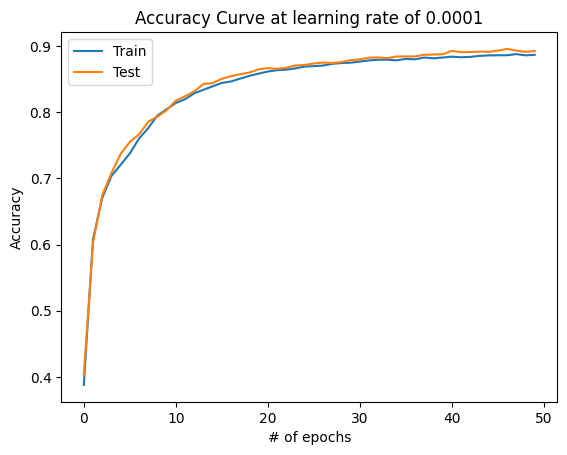

In [ ]:
compare_lr()